In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from random import random

In [2]:
import os

In [3]:
from lcmcmc.utils import get_data_dir_path

# Load data

In [12]:
new_object_df = pd.read_csv(os.path.join(get_data_dir_path(), "perfect_sims.csv"))

The perfect simulations are simulated for LSST so they have 6 differnet bands. Since right now we run the tests on the ZTF data which has only the g and r bands, we will use only these 2 from LSST for compution

# RUN MCMC

In [9]:
from lcmcmc.model import jd_model
import jax.numpy as jnp
import jax
import tensorflow_probability.substrates.jax as tfp

2023-04-17 08:29:59.482303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
rng = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [13]:
index = np.zeros((len(new_object_df), 2), dtype=np.int32)

index[:, 0] = new_object_df["object_index"]
index[:, 1] = new_object_df["band_index"]

x_range = np.asarray(new_object_df["time"])

observed_value = jnp.array(np.asarray(new_object_df["flux"]), dtype=jnp.float32)
observed_sigma = jnp.array(np.asarray(new_object_df["fluxerr"]), dtype=jnp.float32)

jd = jd_model(index, x_range)

In [14]:
# Run the mcmc

run_mcmc = jax.jit(
    lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=4, 
        num_adaptation_steps=100, 
        seed=seed,
        sigma=observed_sigma, 
        obs=observed_value,
    )
)

rng, sample_rng = jax.random.split(rng, 2)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)

In [15]:
from lcmcmc.parametric_fits import parametric_fn
import matplotlib.pyplot as plt

0


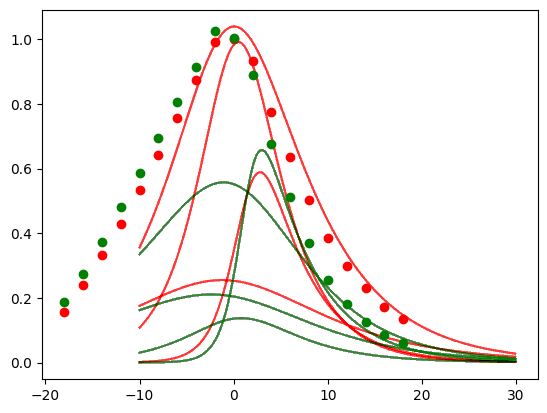

1


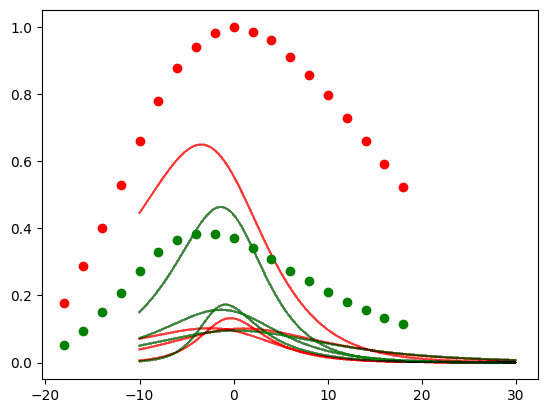

2


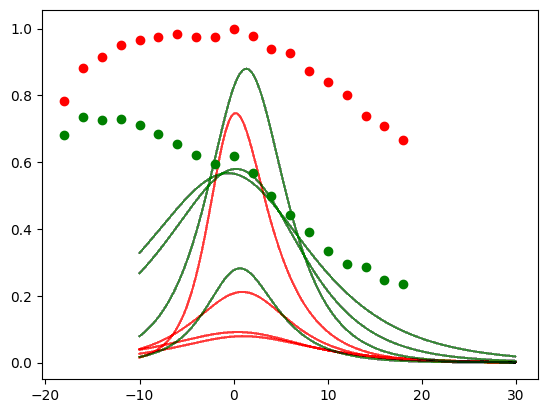

3


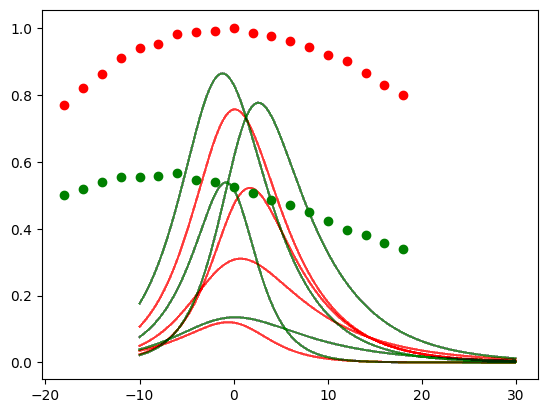

4


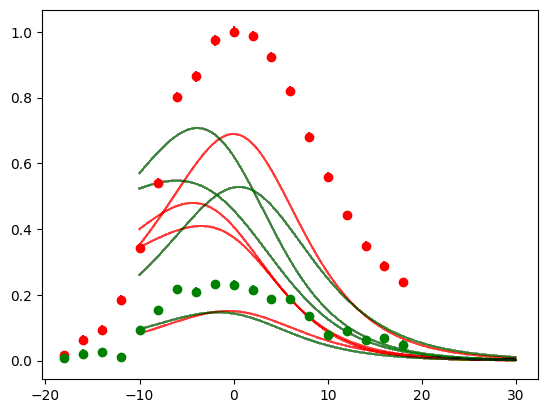

5


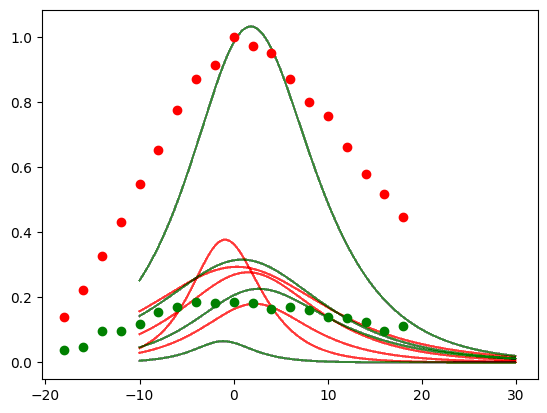

6


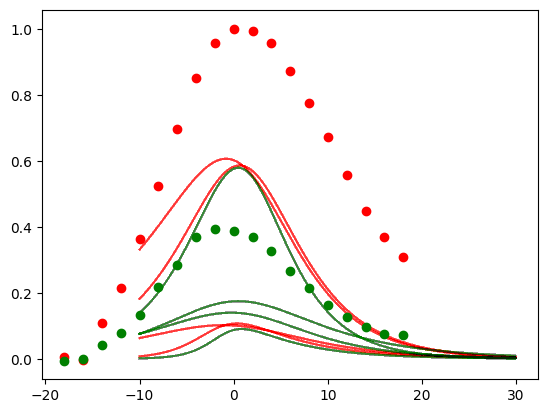

7


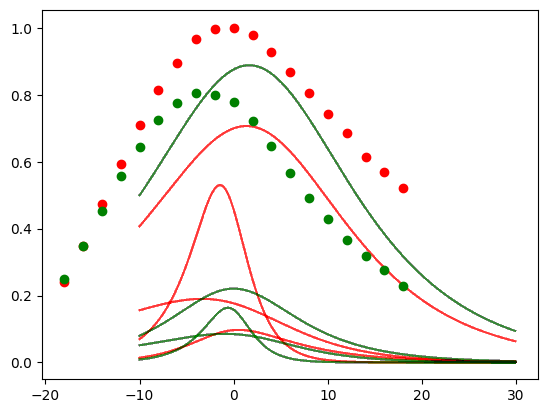

8


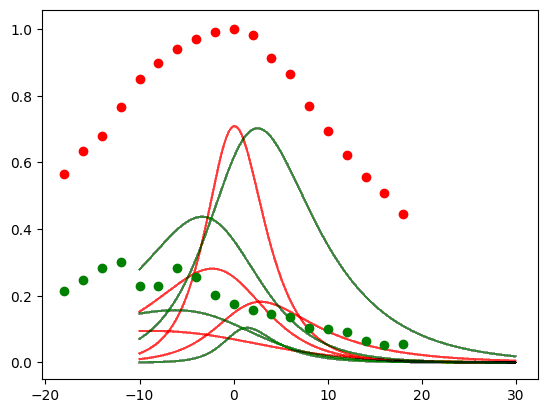

9


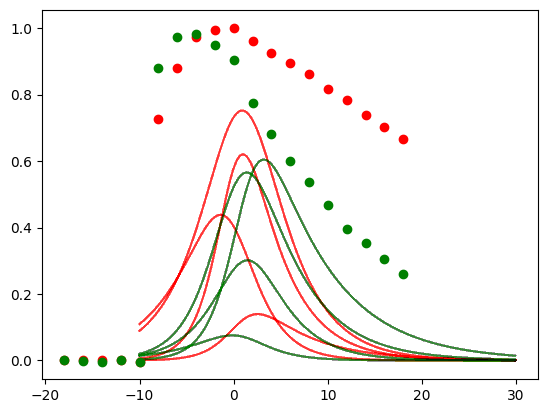

10


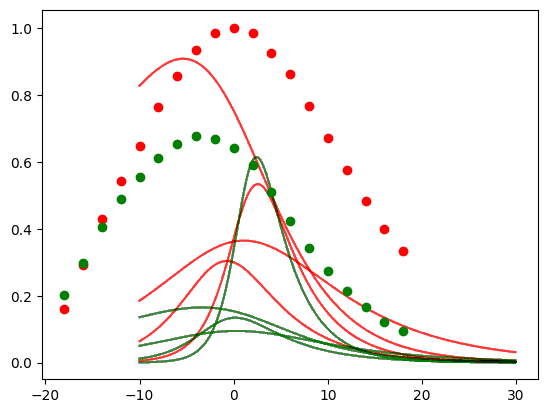

11


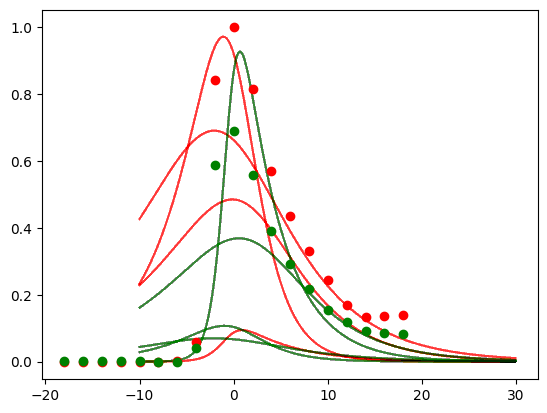

12


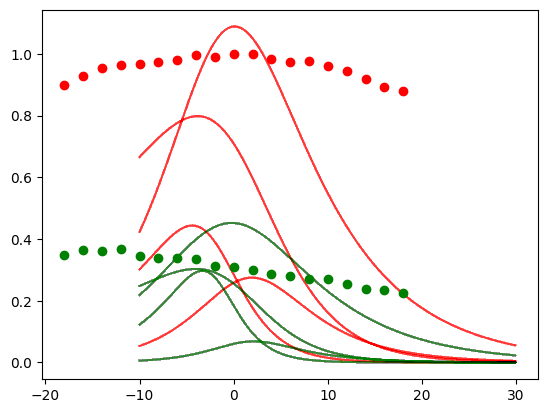

13


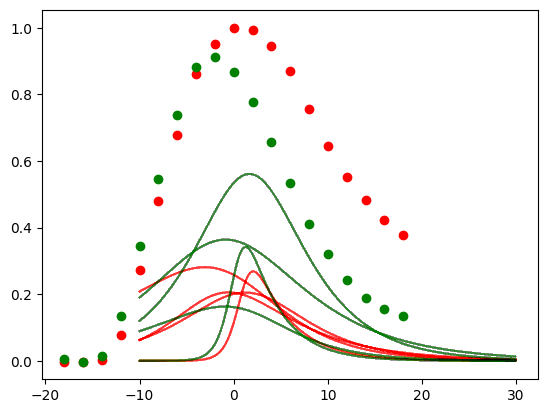

14


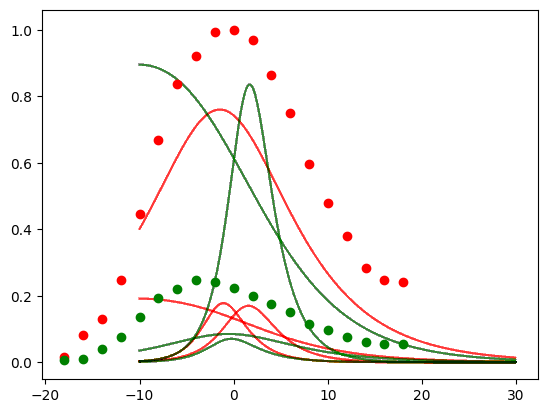

15


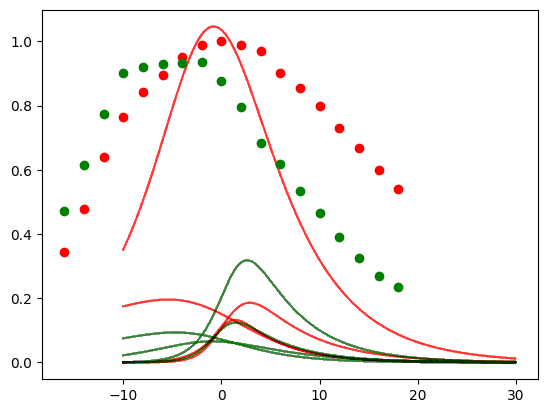

16


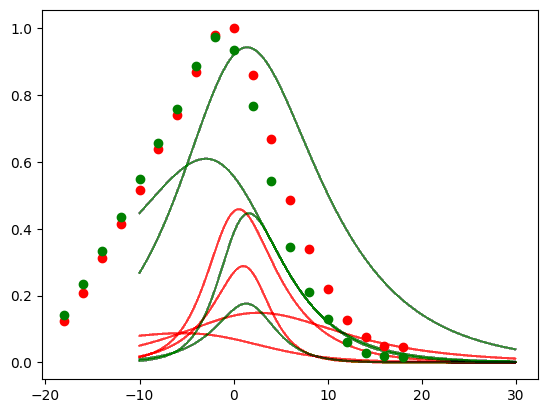

17


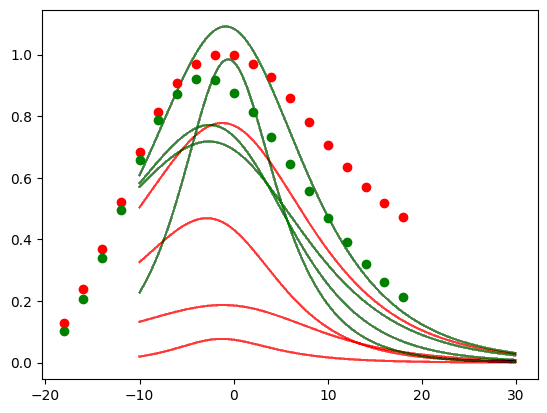

18


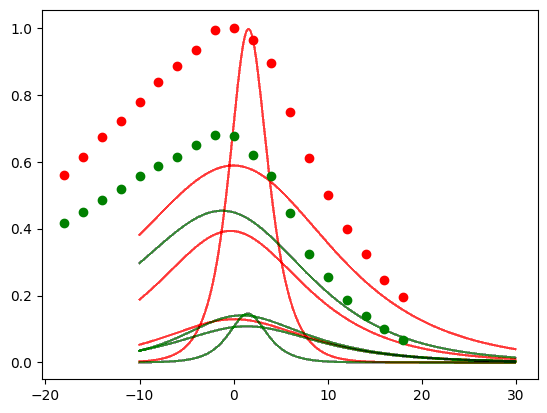

19


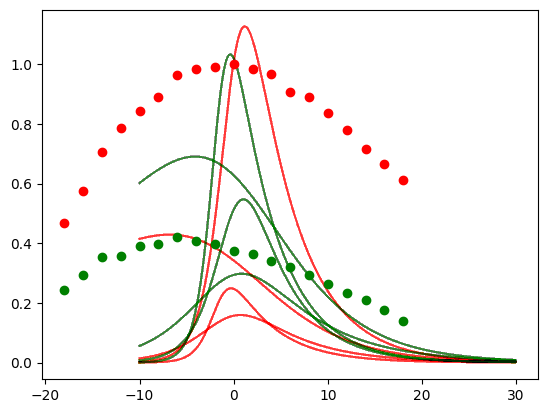

20


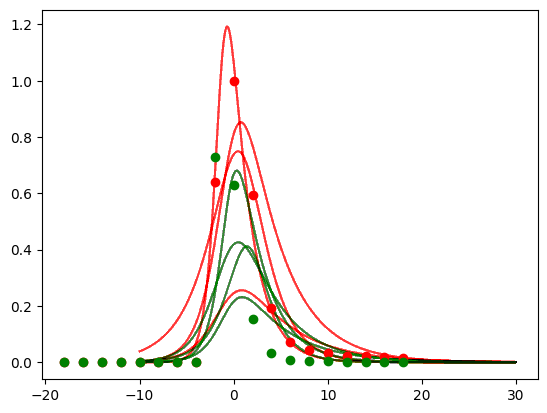

In [16]:
colors = ['r', 'g']
for event_num in range(len(index)):
    print(event_num)
    plt.figure()
    object_df = new_object_df[new_object_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):
            for chain_num in range(4):
                t0 = mcmc_samples.t0[sample_no, chain_num, event_num, band]
                t_rise = mcmc_samples.t_rise[sample_no, chain_num, event_num, band]
                t_fall_ = mcmc_samples.t_fall_[sample_no, chain_num, event_num, band]
                t_fall = t_fall_ + t_rise
                amp = mcmc_samples.amp[sample_no, chain_num, event_num, band]

                predictions = parametric_fn(t0, t_rise, t_fall, amp, np.arange(-10,30, .1))
                plt.plot(np.arange(-10,30, .1), predictions, alpha=.01, color=colors[band])

        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])

    if event_num==20:
        break
    plt.show()